In [1]:
import hylite
from hylite import io
import numpy as np

### 1. Spectral interpretation for geologists

Spectral data captures a huge amount of information about rock composition and fabric, but can be very difficult to interpret due to the complex processes involved. Interpretations generally take one of three different strategies:

1. knowledge based: use understanding of mineral's spectral characteristics to map e.g. specific minerals.
2. supervised: classify lithology or map mineral abundance based on (large) training datasets. 
3. unsupervised: identify spatial domains or clusterings that have similar spectral properties for e.g. data exploration.

For most geological applications there is insufficient training data available for fully supervised approaches, so most applications use knowledge based and/or unsupervised approaches. The following section briefly summarieses some basic knowledge-based analyses and demonstrates them on the example data.

#### Absorbtion features
-----

Knowledge based interpretations generally rely on the interpretation of spectral absorbtion features. These are distinct minima in a materials reflectance spectra caused by absorbtion (rather than reflection) of light at very specific wavelengths. By quantifying the position and (relative) depths of these features it is possible to estimate (typically in a relative sense) the e.g. abundance, composition and crystalinity of spectrally active minerals. 

In the SWIR range the most spectrally active minerals are phyllosilicates such as clay, chlorite and mica. These will be the focus of the following exercises.

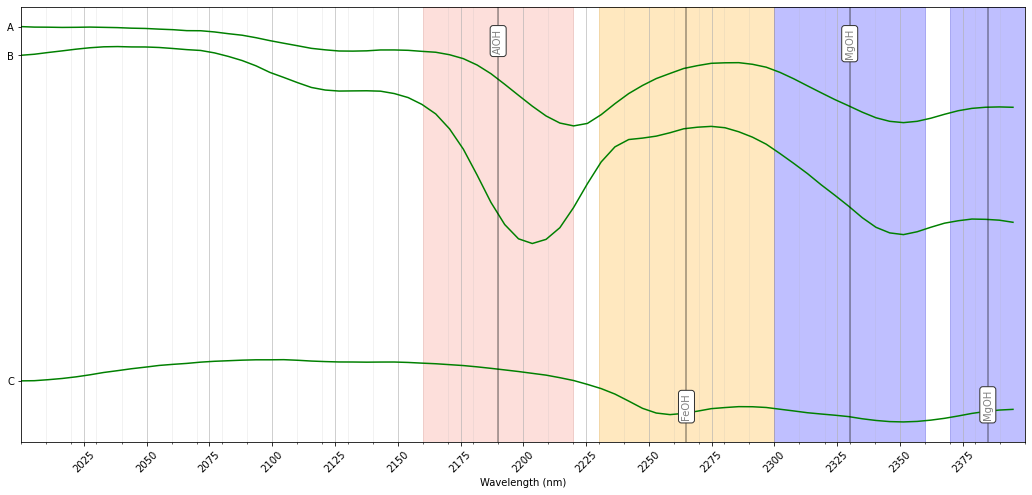

In [2]:
lib = io.load( 'test_data/library.csv' ) # load the spectral dataset
fig,ax = lib.quick_plot(band_range=(2000.,2400.)) # plot it
ax.set_xlim(2000.,2400.)
ax.set_xticks(np.arange(2025,2400,25))
ax.set_xticklabels(np.arange(2025,2400,25))
ax.set_yticklabels(["C","B","A"]) # hide answers ;-)
ax.set_xlabel("Wavelength (nm)")
fig.show()

Absorbtions in the SWIR range are commonly caused by *AlOH*, *FeOH* and *MgOH* bonds in phyllosilicate minerals. The position of these absorbtions is labelled on the above plot. White mica minerals and clays have a characteristic AlOH feature at ~2200 nm, while chlorite and amphibole minerals generally have absorbtions at ~2260 nm (FeOH). Most phyllosilicate minerals also have an absorbtion feature at ~2340 nm.


-----
**Exercise**: *Interpret the spectra in the spectral library from Corta Atalaya to identify the major spectrally active minerals in each sample. Which do you think contains chlorite? Which contains white mica? Does the position of the various absorbtion features vary? What could this indicate?*


-----

Large reference libraries containing the spectral signature of different minerals have been built by e.g. the USGS. These aid the manual (and automated) identification of minerals from their spectra. The USGS library can be conveniently searched using [iSpec](https://www.samthiele.science/app/iSpec/index.html).

-----
**Exercise**: *Use [iSpec](https://www.samthiele.science/app/iSpec/index.html) to check your interpretations of the spectra above. Do you think these spectra conclusively identify the minerals? What could explain the shift in AlOH position between samples A and B?*


-----

### Mapping features

There are a wide range of methods for mapping minerals (and rock types) based on their characteristic absorbtion features. These include (1) band ratio techniques (2) minimum wavelength mapping and (3) spectral unmixing. 

We will explore methods (1) and (2) in the rest of this notebook.

#### Band ratios
--------

Band ratios can be constructed to (among other things) measure the general slope of the spectra across specific regions. Absorbtion features will have a larger slope than spectrally flat (absorbtion-free) regions, and this slope will corellate with absorbtion depth. 

Hence, we can map the relative abundance of e.g. AlOH containing minerals (clays and white micas) using a band ratio between a reference wavelength (e.g. 2100 nm) and the absorbed wavelength (2200 nm). To increase signal to noise ratio it is also common practice to average several bands in the numerator and denominator of these band ratios.

-------
**Exercise**: *Use a band ratio to map the relative depth of the AlOH feature, and by proxy abundance of white-mica and clay minerals. Which of the hand samples do you think comes from the chlorite altered part of the deposit? Can you come up with a different band ratio that instead maps the chlorite?*

In [3]:
# load datasets to play with
image = io.load( 'test_data/image.hdr' )
cloud = io.load( 'test_data/hypercloud.ply' )

test_data/image.hdr test_data/image.dat


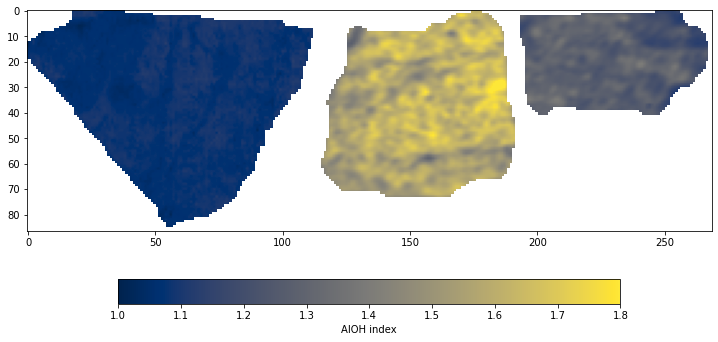

In [4]:
from hylite.analyse import band_ratio # import the band ratio function

br = band_ratio( image, 2110., 2200.) # band ratio = 2075 nm / 2200 nm
fig,ax =br.quick_plot(0, cmap='cividis', vmin=1.0, vmax=1.8)
cbar = fig.colorbar( ax.cbar, orientation='horizontal', shrink=0.5)
cbar.set_label("AlOH index")
fig.show()

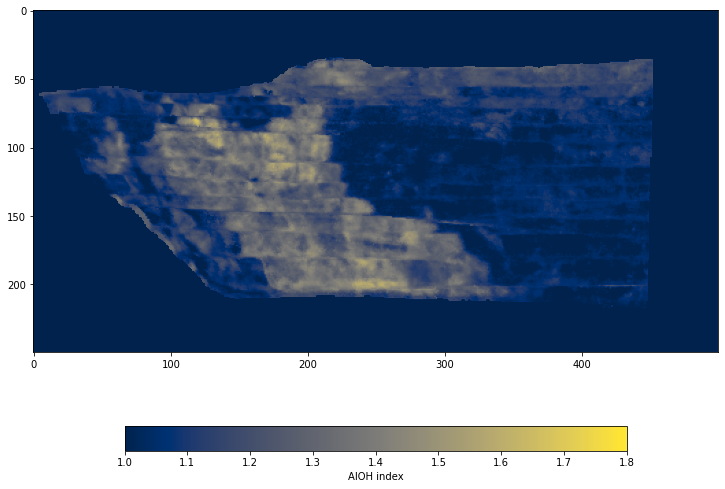

In [5]:
# also map the band ratio in the open pit using the hypercloud
br = band_ratio( cloud, 2110., 2200.) # band ratio = 2075 nm / 2200 nm
fig,ax =br.quick_plot(cloud.header.get_camera(0), 0, cmap='cividis', 
                      fill_holes=True, vmin=1.0, vmax=1.8)
cbar = fig.colorbar( ax.cbar, orientation='horizontal', shrink=0.5)
cbar.set_label("AlOH index")
fig.show()

------

### Hull corrections

You may have already noticed that the absorbtion features in more reflective samples tend to be deeper than in less reflective ones. To help exaggurate these features, it is common to apply a *hull correction* to spectra to normalise the difference in reflectivity and exaggurate local absorbtions by removing long wavelength trends in the data.

For example, if we apply a hull correction to our spectral library it is much easier to identify the FeOH absorbtion in the chloritic sample, as well as the shift in the position of the AlOH feature between the phengitic and muscovitic altered samples.

In [6]:
from hylite.correct import get_hull_corrected # import hull correct function
lib = get_hull_corrected( lib ) # apply the hull correction

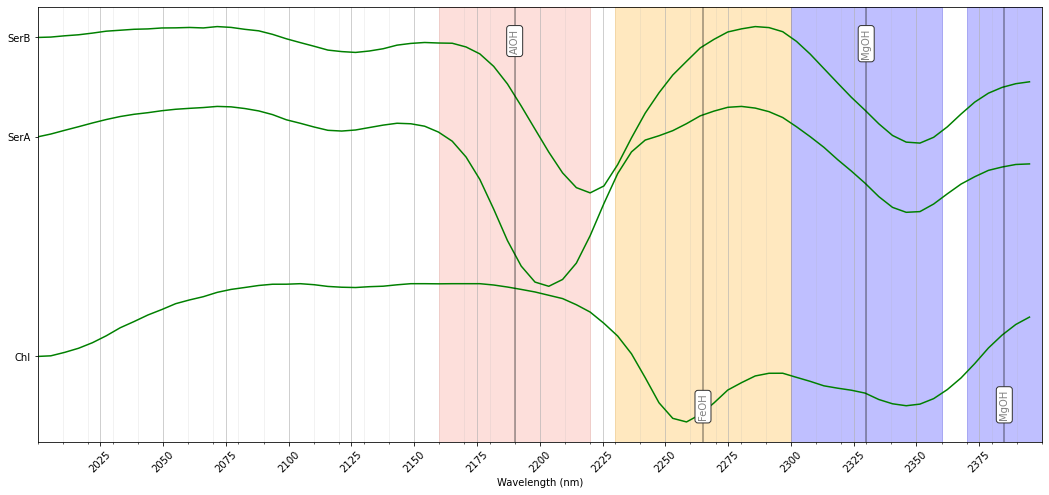

In [7]:
fig,ax = lib.quick_plot(band_range=(2000.,2400.)) # plot it
ax.set_xlim(2000.,2400.)
ax.set_xticks(np.arange(2025,2400,25))
ax.set_xticklabels(np.arange(2025,2400,25))
ax.set_xlabel("Wavelength (nm)")
fig.show()

----

**Exercise**: *Apply a hull correction to the image dataset and then recalculate the band ratio map of AlOH absorbtion depth. Does this change the result much?*


In [53]:
# your funky code goes here

------



### Minimum wavelength maps

For some minerals, the precise position of characteristic absorbtion features can be an excellent indicator of mineral composition. For example, phengitic and muscovitic micas can be discriminated based on the position of the AlOH feature, which varies between ~2190 and 2220 nm based on the mica composition. 

This sensitivity to the precise mineralogy of key indicator/alteration minerals is one of the key advantages of hyperspectral mapping in exploration, as these subtle changes are often difficult to detect using other methods. 

The most common method for mapping these changes (for e.g. alteration vectoring) is to fit an absorbtion feature (normally represented by a polynomial, gaussian or lorentzian function) to the observed spectra in order to more accurately resolve the exact position of the reflectance minima of interest. This is called *minimum wavelength mapping*, or MWL.

In [8]:
from hylite.analyse import minimum_wavelength, colourise_mwl # import minimum wavelength mapping functions

In [9]:
# calculate minimum wavelength map
mwl = minimum_wavelength( cloud, # data to map
                          2170., # start of mapping range 
                          2240., # end of mapping range
                          method='minmax', # method to apply. Change to 'gauss' for more accurate (but slower) result
                          trend='hull' ) # always apply a hull correction to the data first to remove the trend

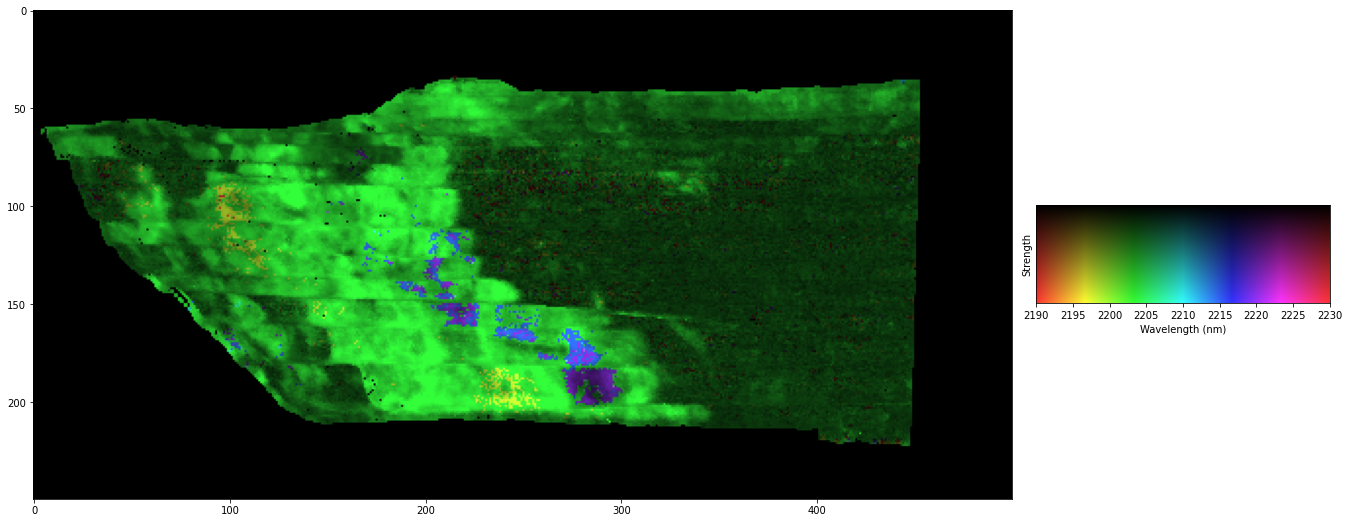

In [10]:
# convert this map (which has four bands that describe feature: position, width, depth and strength [goodness of fit])
# to a false colour RGB map that can be visualised
rgb, leg = colourise_mwl( mwl, val_map=(0.0,0.25), hue_map=(2190., 2230.)) # generate false colour mapping
fig,ax = rgb.quick_plot( cloud.header.get_camera(0), (0,1,2), fill_holes=True) # plot it
leg.plot(ax, pos=(1.025,0.4) ) # add the legend
fig.show()

-------
**Exercise**: *Generate a minimum wavelength map for the image showing the rock samples. Based on these results, where in the scene do you think they came from?*

In [80]:
# put your code here

-----
### Towards data driven approaches

Finally, unsupervised statistical and machine learning approaches can be used to explore the clustering of data in hyperspectral space and e.g. qualitatively identify lithological units (even if we don't specifically know what these are).

These approaches rely on dimensionality reduction techniques that compress much of the data variability into as few bands as possible (e.g. principal component analysis). One commonly applied method is to calculate the *minimum noise fraction*, which is like a PCA but less sensitive to highly noisy data.

In [26]:
from hylite.filter import MNF, PCA

Warning - image contains negative pixels. This can cause unstable behaviour...


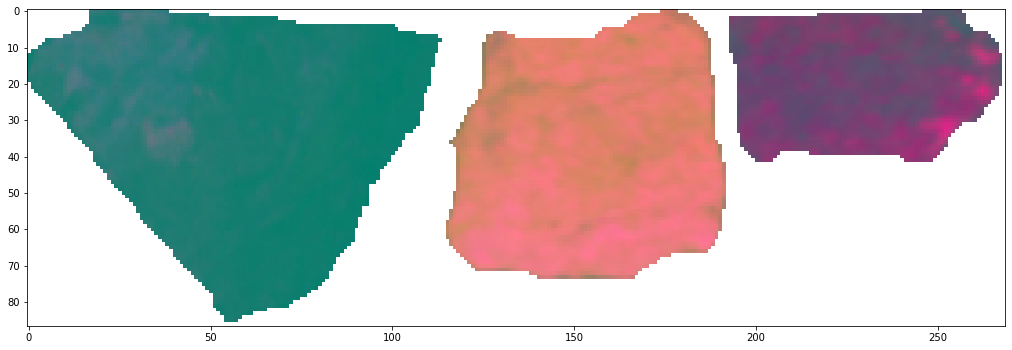

In [46]:
mnf, w = MNF(image, output_bands=5) # calculate MNF filter from image
fig,ax = mnf.quick_plot((0,1,2)) # map the first 3 bands. Note that these have no physical meaning anymore.
fig.show()

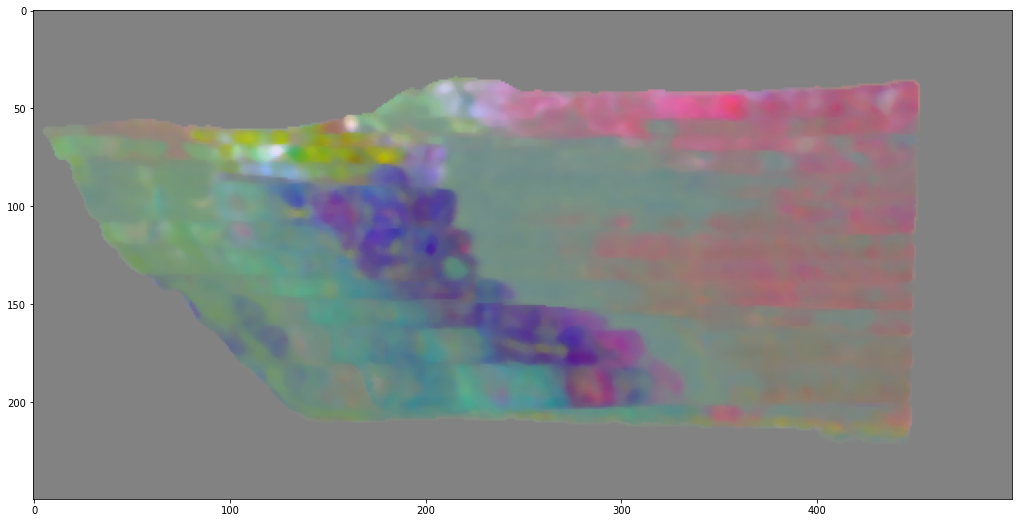

In [45]:
mnf, w = MNF(cloud, output_bands=5) # calculate MNF filter from hypercloud
fig,ax = mnf.quick_plot(cloud.header.get_camera(0), (1,2,3), fill_holes=True, despeckle=True) #note that these bands are NOT comparable to the previous figure!
fig.show()

These dimensionality reduced datasets can then be used for a wide variety of applications, including but not limited too endmember extraction, unsupervised classification and/or supervised machine learning.


-----

**Final exercise (advanced)**:*The MNF bands computed for the hyperspectral image are not comparable with the ones computed for the hypercloud, as this statistical approach generates the bands using a different combination of weights. Can you compute an MNF transform on the image data, and then apply it to the hypercloud dataset? Note that: (1) the MNF function returns the linear weights list (`w`) that were used to map the hyperspectral data onto each MNF bands; (2) specific bands can be extracted from the image dataset such that it has matching wavelengths (and number of bands) to the hypercloud dataset using `foo.export_bands(...)`. How comparable do you think the outputs are? Can you revise your guess as to where each of the samples came from?*


In [29]:
subset = image.export_bands( (cloud.get_wavelengths()[0], cloud.get_wavelengths()[-1]+5) ) #n.b. add 5 nm to get correct bands
assert subset.band_count() == cloud.band_count()

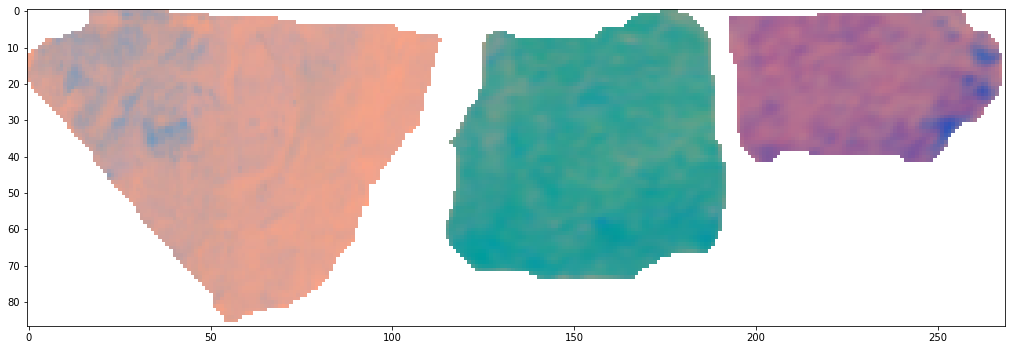

In [44]:
mnf, w = MNF(subset) # calculate MNF on subset
fig,ax = mnf.quick_plot((0,1,2))
fig.show()

In [38]:
mnf_cloud = cloud.copy(data=False) # make a copy of the hypercloud to store MNF transform in
mnf_cloud.data = np.zeros( (mnf_cloud.point_count(), w.shape[0]))
for i in range(w.shape[0]): # loop through output bands
    mnf_cloud.data[:,i] = np.dot( cloud.data, w[i, :] ) # compute values using linear transform

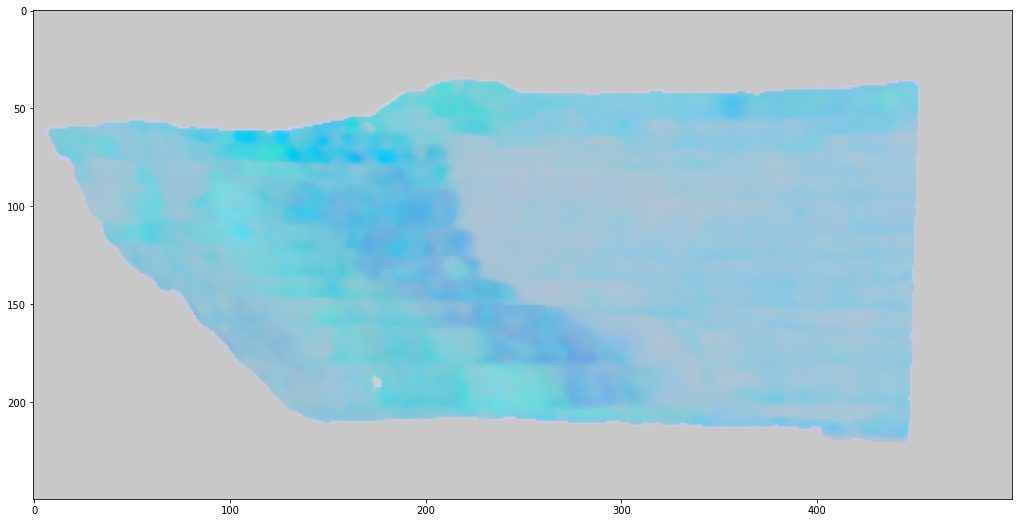

In [43]:
fig,ax = mnf_cloud.quick_plot(cloud.header.get_camera(0), (0,1,2), fill_holes=True, despeckle=True)
fig.show()

----